In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# Import Local funcs
import sys
sys.path.append('../')
from utils.utils import *

# Import Data

In [2]:
X, y = get_training()


In [4]:
# Drop Object Columns
X_obj_dropped = X.select_dtypes(exclude=['object'])

In [56]:
# Convert categorical columns to integers - For Boosting
# OR, colnames of categorical columns
categoricals = X.select_dtypes('object').columns
indexes_of_categories = [X.columns.get_loc(col) for col in categoricals]

X_encoded = X.copy()
for col in categoricals:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes


In [5]:
# Choose the X from above to split for training (X_obj_dropped or X_encoded)
X_to_split = X_obj_dropped

# Make Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_to_split, y, test_size = 0.3, random_state = 42)

# 01 - Naive LGB

In [6]:
# Naive LGBM
clf_naive = lgb.LGBMClassifier()
clf_naive.fit(X_train, y_train)

/Users/zaza/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zaza/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier()

In [18]:
clf_naive.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [28]:
# Evaluate Train Accuracy
y_pred_train = clf_naive.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'Train Accuracy: {train_accuracy:.2f}')

Train Accuracy: 0.79


In [29]:
# Evaluate Test Accuracy
y_pred_test = clf_naive.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

Test Accuracy: 0.64


In [69]:
# Evaluate MultiLogLoss
y_pred_proba = clf_naive.predict_proba(X_test)
multi_log_loss = log_loss(y_test, y_pred_proba)
print(f'Multi Log Loss: {multi_log_loss:.4f}')

Multi Log Loss: 0.8598


In [34]:
# Evaluate CV Loss
clf_naive_params = clf_naive.get_params()
clf_naive_params['objective'] = "multiclass"
clf_naive_params['num_classes'] = 5
del clf_naive_params['silent']
del clf_naive_params['importance_type']
clf_naive_CV = lgb.cv(clf_naive_params, lgb.Dataset(X_train, y_train), nfold=5, metrics='multi_logloss')
print(f'CV Multi Log Loss: {clf_naive_CV["multi_logloss-mean"][-1]:.4f}')
print(f'CV Multi Log Loss SD: {clf_naive_CV["multi_logloss-stdv"][-1]:.4f}')

/Users/zaza/miniconda3/lib/python3.10/site-packages/lightgbm/engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 26880, number of used features: 420
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 26880, number of used features: 420
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 26880, number of used features: 420
[LightGBM] [Warning] Auto-choosing row-wise multi-threadi

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

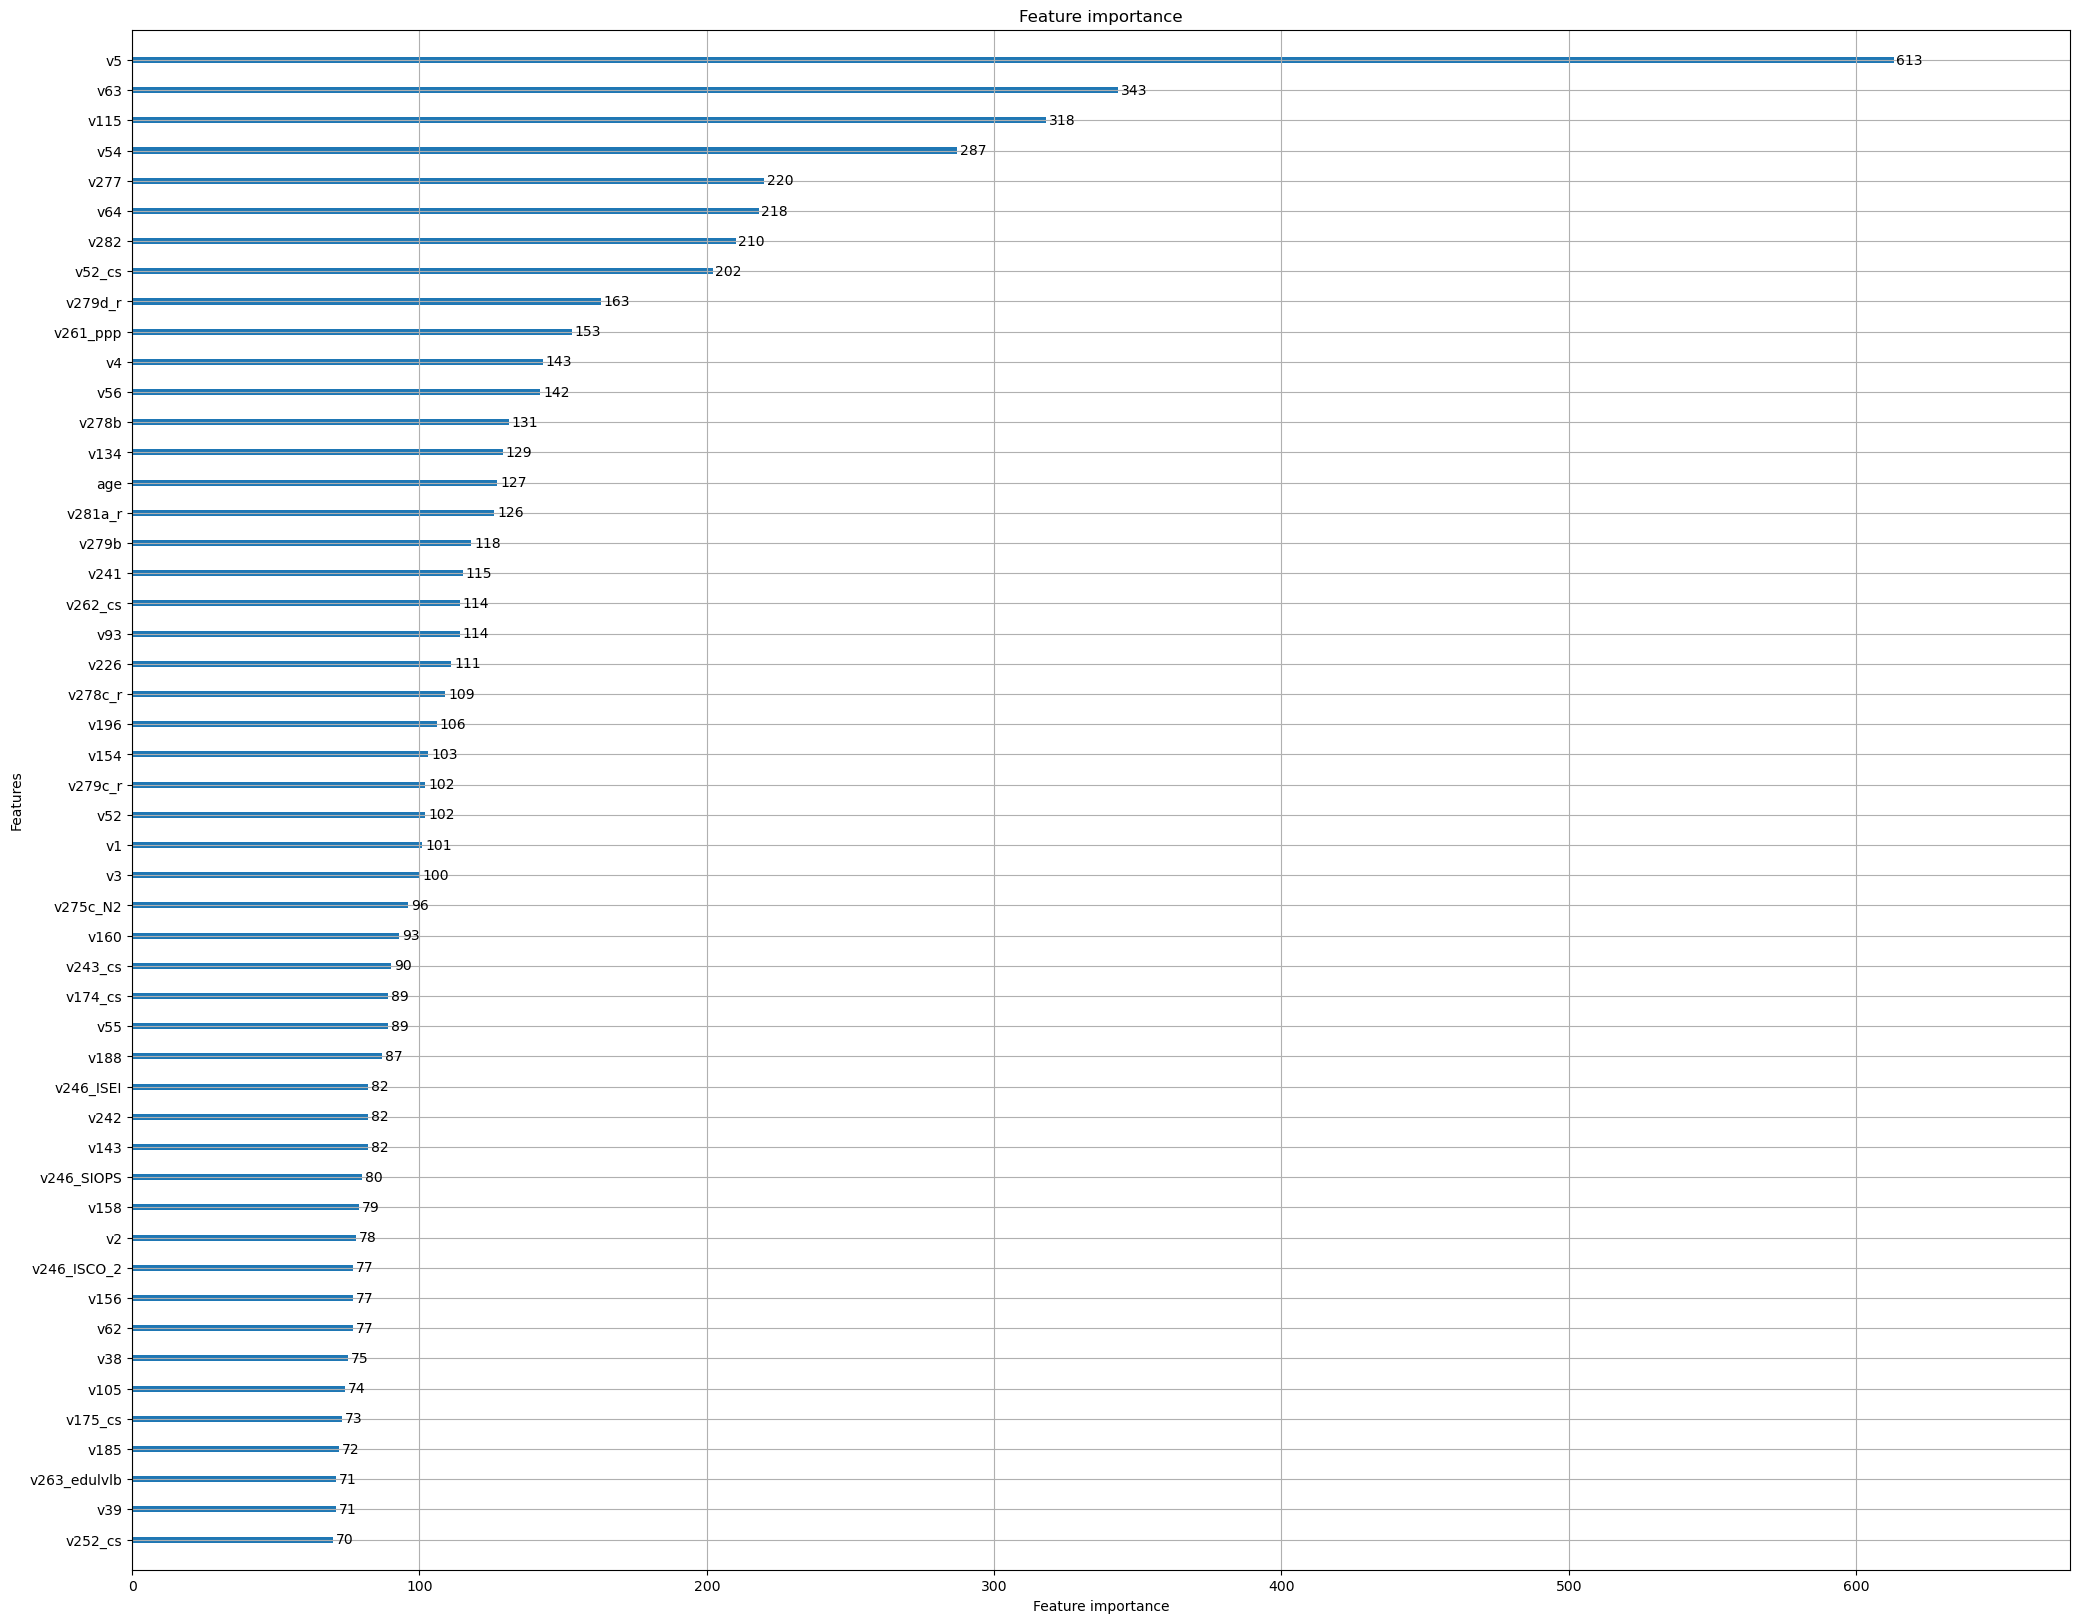

In [22]:
lgb.plot_importance(clf_naive, max_num_features=50, figsize=(25,20))

# 02 - LGB.Train Method
This model uses a single Train/Test Split

In [36]:
# Prepare lbg dataset
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test, reference=d_train)
# ex: train_data = lgb.Dataset(data, label=label, feature_name=['c1', 'c2', 'c3'], categorical_feature=['c3'])

In [48]:
# Train Model
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",

    "num_leaves": 10,
    # "max_depth": 5,
    "learning_rate": 0.01,
    #"n_estimators": 1000,
    #"subsample_for_bin": 200000,
    #"class_weight"='balanced',
    #"min_child_samples": 20,
    #"reg_alpha": 0.1,
    #"reg_lambda": 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,                
    
    "boost_from_average": True,
    "num_class" : 5,
    "verbose": 1,
}

model = lgb.train(
    params,
    d_train,
    num_boost_round=10000,
    valid_sets=d_test,
    #categorical_feature=indexes_of_categories,
    callbacks=[lgb.early_stopping(50)]
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 33600, number of used features: 420
[LightGBM] [Info] Start training from score -4.282397
[LightGBM] [Info] Start training from score -1.579677
[LightGBM] [Info] Start training from score -1.216351
[LightGBM] [Info] Start training from score -1.261657
[LightGBM] [Info] Start training from score -1.606169
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2172]	valid_0's multi_logloss: 0.846773


In [53]:
print(model.best_iteration)
print(model.best_score)

2172
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('multi_logloss', 0.8467727277828399)])})


In [38]:
# Evaluate Train Accuracy
y_train_pred_prob = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {train_accuracy:.2f}')

Train Accuracy: 0.74


In [39]:
# Evaluate Test Accuracy
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
train_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {train_accuracy:.2f}')

Test Accuracy: 0.64


In [40]:
# Evaluate MultiLogLoss on Test Set
y_pred_proba = model.predict(X_test)
multi_log_loss = log_loss(y_test, y_pred_proba)
print(f'Multi Log Loss: {multi_log_loss:.5f}')

Multi Log Loss: 0.84677


In [50]:
# CV Log Loss
cv_results = lgb.cv(
    params,
    d_train,
    num_boost_round=2200,
    nfold=5,
    stratified=False,
    #categorical_feature = indexes_of_categories,
    callbacks=[lgb.early_stopping(50)],
)

print(f'CV: Multi Log Loss: {cv_results["multi_logloss-mean"][-1] :.5f}')
print(f'CV: Multi Log Loss: {cv_results["multi_logloss-stdv"][-1] :.5f}')


CV: Multi Log Loss: 0.85143
CV: Multi Log Loss: 0.01412


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

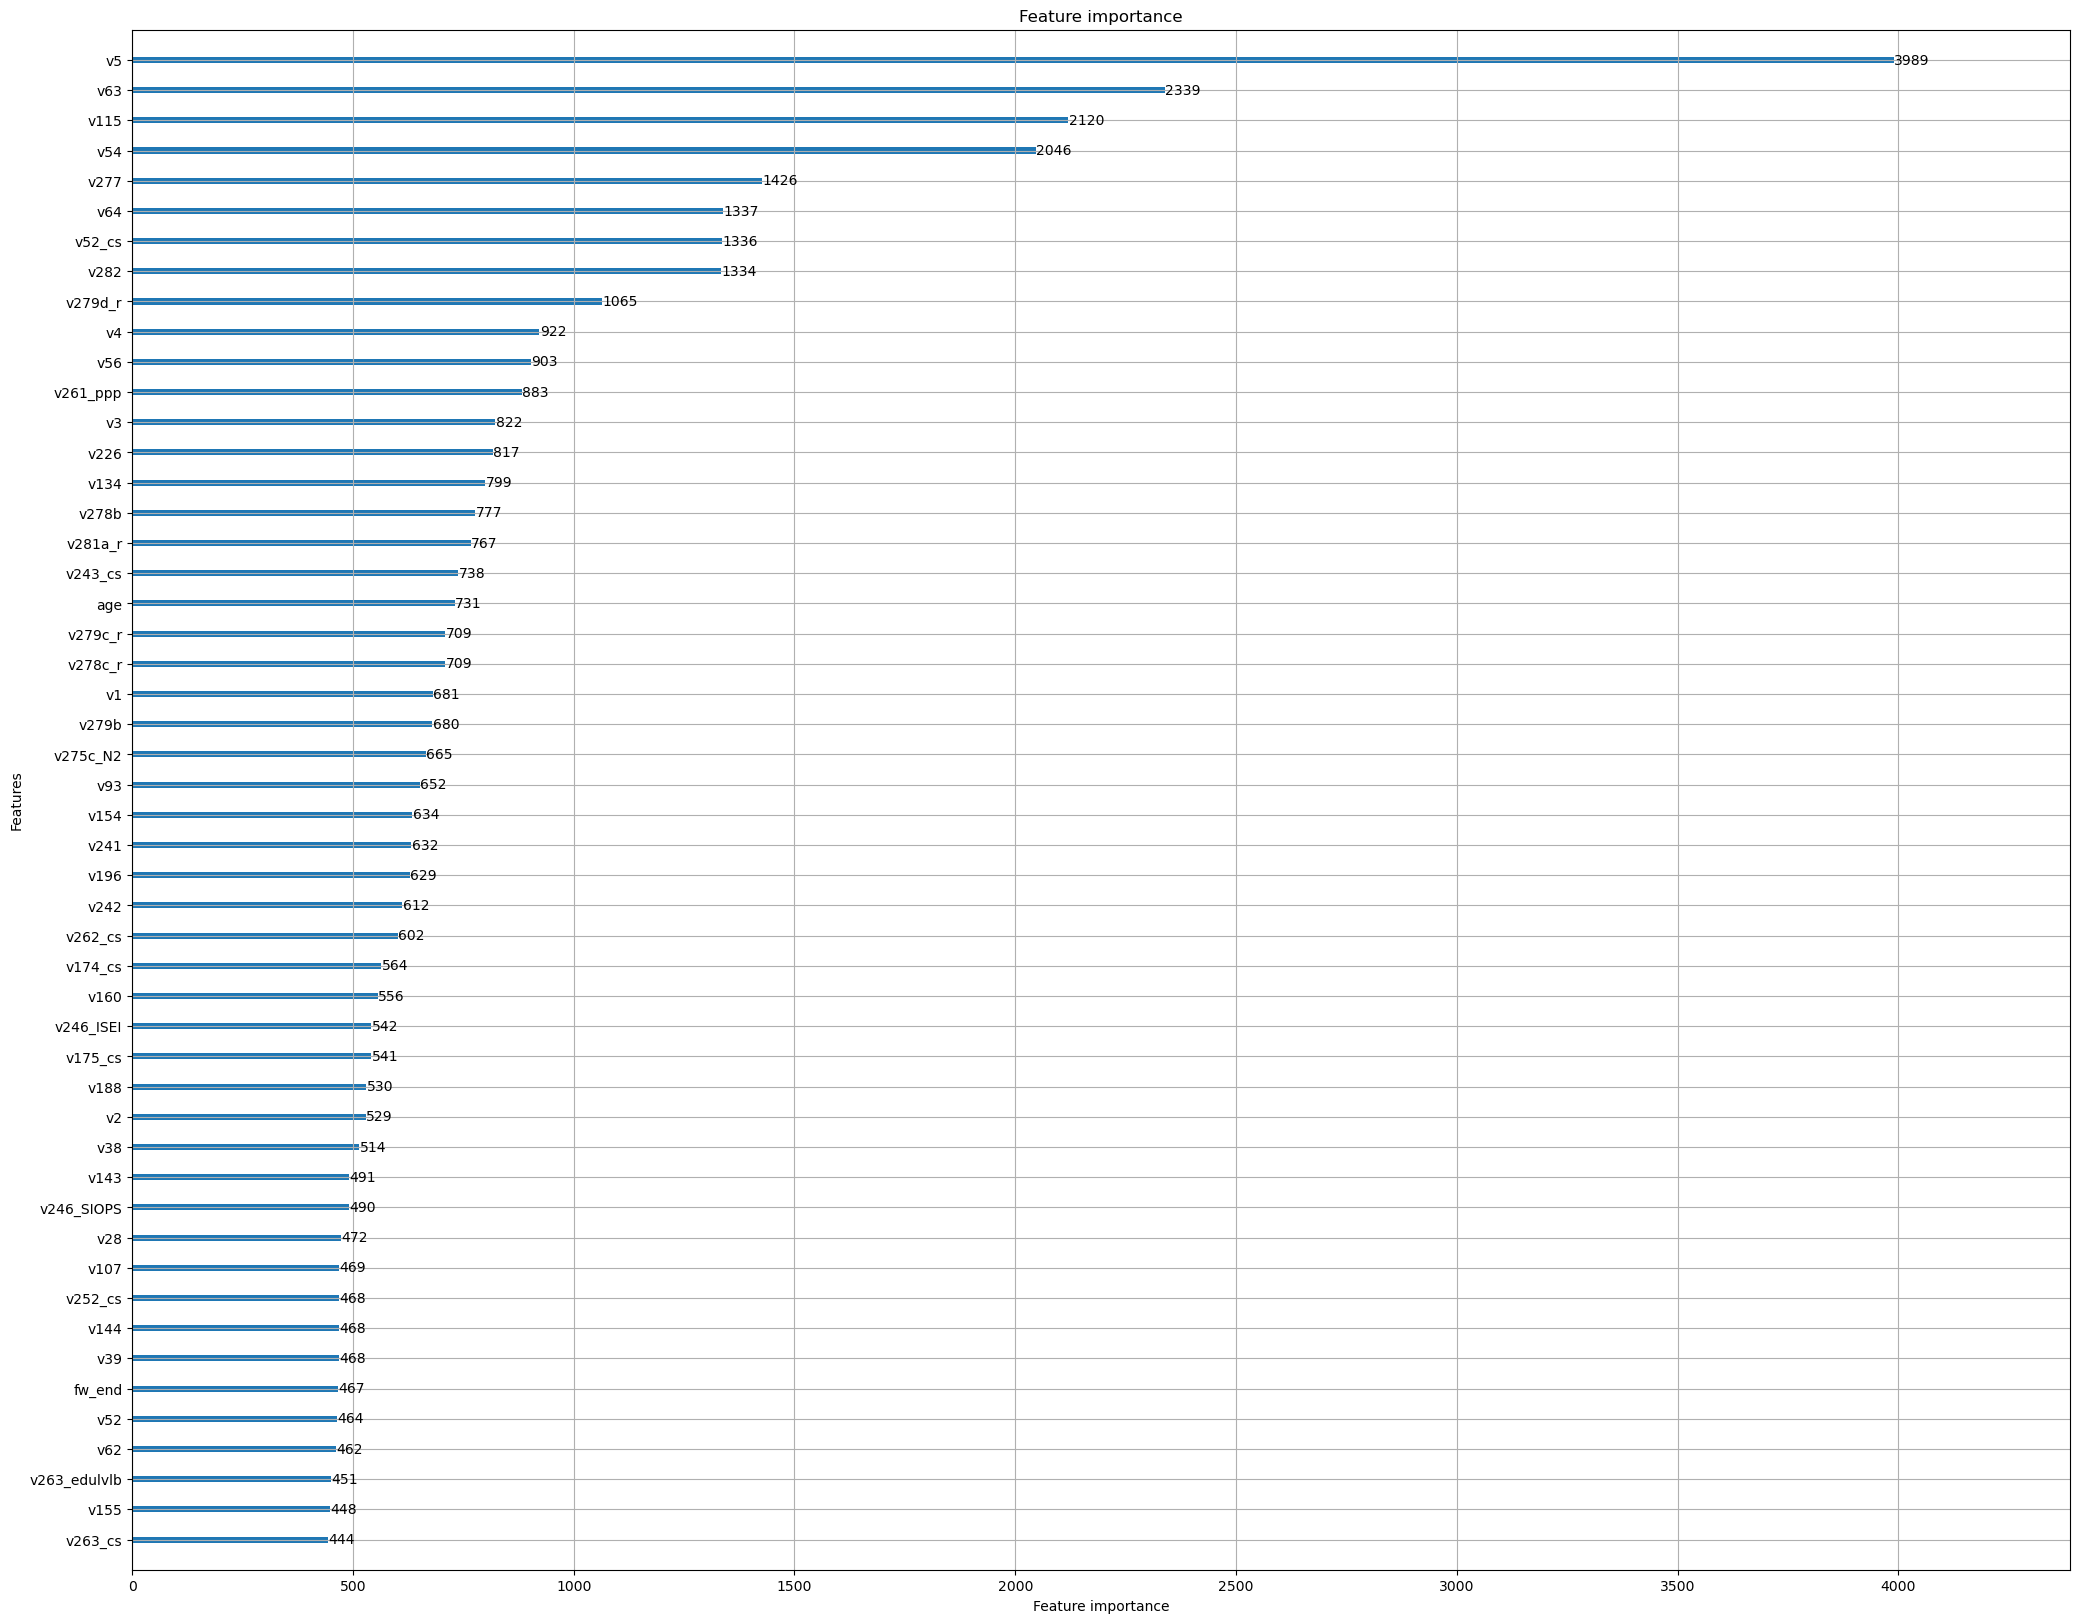

In [52]:
lgb.plot_importance(model, max_num_features=50, figsize=(25,20))

# Submission

In [56]:
# Train Model on Full Data
final_model = lgb.LGBMClassifier(**params, n_estimators=model.best_iteration)
final_model.fit(X_obj_dropped, y)

/Users/zaza/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zaza/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 420
[LightGBM

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, boost_from_average=True,
               feature_fraction=0.8, learning_rate=0.01, metric='multi_logloss',
               n_estimators=2172, num_class=5, num_leaves=10,
               objective='multiclass', verbose=1)

In [58]:
X_test_subm = get_test()
X_test_subm = X_test_subm.select_dtypes(exclude=['object'])
pred_df = get_predictions(final_model, X_test_subm)

TypeError: get_predictions() missing 1 required positional argument: 'name'

In [59]:
# Make a df of preds
predictions = final_model.predict_proba(X_test_subm)
preds_df = pd.DataFrame(predictions, columns=['no answer', 'very important', 'quite important', 'not important', 'not at all important'])
preds_df.index.name = 'id'
print(preds_df.shape)
preds_df.head()

(11438, 5)


,no answer,very important,quite important,not important,not at all important
id,,,,,
0,0.000814,0.825706,0.103340,0.061345,0.008795
1,0.006285,0.089948,0.820101,0.077869,0.005798
2,0.012762,0.172417,0.506249,0.290961,0.017611
3,0.018578,0.092841,0.696277,0.160324,0.031981
4,0.004445,0.300083,0.636690,0.051619,0.007163


In [60]:
# Save to CSV
preds_df.to_csv('../data/predictions/DefaultTune_ObjDropped_preds.csv')
